In [200]:
# imports
import os
from packaging import version
import shutil

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorboard as tb


In [ ]:
# check tensorboard version
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    'This notebook requires TensorBoard 2.3 or later.'
print("TensorBoard version: ", tb.__version__)

In [353]:
# copy relevant model metrics into seperate folder and upload to tensorboard dev
data_filter = 'test' # 'train', 'test' or 'validation'
model_filter = 'resnet'# 'basic' or 'resnet'
log_path = '../logs/scalars'
upload_path = '../tensorboard_upload/'
os.mkdir(upload_path)

for (dirpath, dirnames, filenames) in os.walk(log_path):
    # filter dirs
    if data_filter in dirpath and model_filter in dirpath:

        from_directory = dirpath
        to_directory = upload_path + dirpath[16:]

        # copy dir trees
        shutil.copytree(from_directory, to_directory)

# TODO: run in project root
print(f'tensorboard dev upload --logdir=./tensorboard_upload/ --name FLE_{model_filter}_{data_filter}')

tensorboard dev upload --logdir=./tensorboard_upload/ --name FLE_resnet_test


In [352]:
# remove copied dir trees
shutil.rmtree(upload_path)

In [362]:
# TODO: set tensorboard dev ID
experiment_ids = ['Cw4BDWrkTx2kI8A4OzBu5A', 'uLYWP18zQ1eMtDBiLHLHrg'] # [resnet, basic]
all_dfs = []

# download experiment
for ind, id in enumerate(experiment_ids):
    experiment = tb.data.experimental.ExperimentFromDev(id)
    df_temp = experiment.get_scalars()
    
    print(f'{ind}: {df_temp.shape}')
    all_dfs.append(df_temp)

df = all_dfs[0]

if len(all_dfs) > 1:
    for new_df in all_dfs[1:]:
        df = pd.concat([df, new_df])

print(df.shape)
df.head()

0: (1619500, 4)
1: (1780000, 4)
(3399500, 4)


,run,tag,step,value
0,resnet_00000r_14c\20220413-1655\test,batch_accuracy,1,0.125000
1,resnet_00000r_14c\20220413-1655\test,batch_accuracy,2,0.125000
2,resnet_00000r_14c\20220413-1655\test,batch_accuracy,3,0.104167
3,resnet_00000r_14c\20220413-1655\test,batch_accuracy,4,0.125000
4,resnet_00000r_14c\20220413-1655\test,batch_accuracy,5,0.156250


In [398]:
# extract features
df['model'] = df['run'].str.extract('(^[a-z]{5,6})_')
df['data'] = df['run'].str.extract('([a-z]{4,})$')
df['ratio'] = df['run'].str.extract('(\d{5})r').astype(float)
df['ratio'] = df['ratio'] / 100
df['classes'] = df['run'].str.extract('(\d{1,2})c')

df.to_pickle('../logs/fle_testMetrics_raw.pkl')

In [364]:
print(df.columns)
print(df.shape)
print(len(df['run'].unique()))
# print(df["tag"].unique())
df.head()

Index(['run', 'tag', 'step', 'value', 'model', 'data', 'ratio', 'classes'], dtype='object')
(3399500, 8)
191


,run,tag,step,value,model,data,ratio,classes
0,resnet_00000r_14c\20220413-1655\test,batch_accuracy,1,0.125000,resnet,test,0.0,14
1,resnet_00000r_14c\20220413-1655\test,batch_accuracy,2,0.125000,resnet,test,0.0,14
2,resnet_00000r_14c\20220413-1655\test,batch_accuracy,3,0.104167,resnet,test,0.0,14
3,resnet_00000r_14c\20220413-1655\test,batch_accuracy,4,0.125000,resnet,test,0.0,14
4,resnet_00000r_14c\20220413-1655\test,batch_accuracy,5,0.156250,resnet,test,0.0,14


In [395]:
df_aggr = df.query('data == "test" & step == 19 & tag==["epoch_accuracy", "epoch_precision_weighted", "epoch_recall_weighted", "epoch_f1-score_weighted"]')
df_aggr = df_aggr.groupby(['model', 'classes', 'ratio', 'data', 'tag']).mean().reset_index()

df_aggr['delta'] = df_aggr.apply(lambda row:
    row['value'] - df_aggr.query(f'model=="{row.model}" & classes=="{row.classes}" & ratio== 0 & tag=="{row.tag}"').iloc[0]['value'], axis=1
)

df_aggr.to_pickle('../logs/fle_testMetrics_aggregated.pkl')

df_aggr.shape

(156, 8)

------------

#### accuracy plot

In [405]:
df_epoch_accuracy = df_aggr.query("tag == 'epoch_accuracy'")
df_epoch_accuracy = df_epoch_accuracy.groupby(['model', 'classes', 'ratio', 'data', 'tag']).mean().reset_index()
df_epoch_accuracy.head()

,model,classes,ratio,data,tag,step,value,delta
0,basic,14,0.00,test,epoch_accuracy,19.0,0.845858,0.000000
1,basic,14,0.25,test,epoch_accuracy,19.0,0.832078,-0.013780
2,basic,14,0.50,test,epoch_accuracy,19.0,0.841190,-0.004669
3,basic,14,1.00,test,epoch_accuracy,19.0,0.823117,-0.022741
4,basic,14,2.00,test,epoch_accuracy,19.0,0.820331,-0.025527


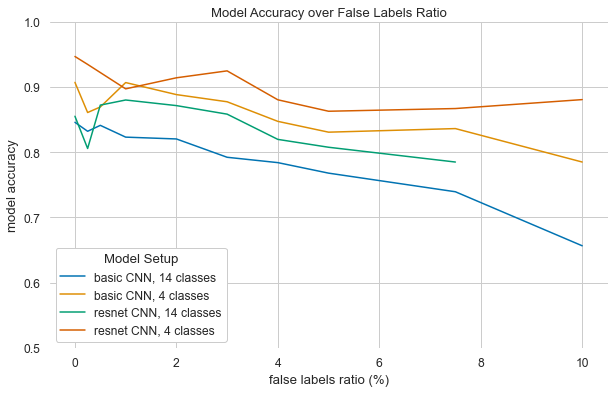

In [460]:
df_hue = df_epoch_accuracy[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_epoch_accuracy,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model accuracy',
            ylim=(0.5,1),
            title='Model Accuracy over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_accuracy.png', dpi=300, facecolor='white')

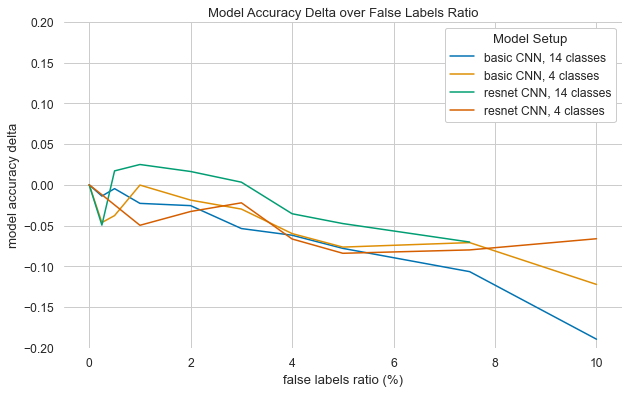

In [461]:
df_hue = df_epoch_accuracy[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_epoch_accuracy,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model accuracy delta',
            ylim=(-0.2,0.2),
            title='Model Accuracy Delta over False Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_accuracy_delta.png', dpi=300, facecolor='white')

------------

#### weighted avg precision plot

In [462]:
df_epoch_precision_w = df_aggr.query("tag == 'epoch_precision_weighted'")
df_epoch_precision_w = df_epoch_precision_w.groupby(['model', 'classes', 'ratio', 'data', 'tag']).mean().reset_index()
df_epoch_precision_w.head()

,model,classes,ratio,data,tag,step,value,delta
0,basic,14,0.00,test,epoch_precision_weighted,19.0,0.858955,0.000000
1,basic,14,0.25,test,epoch_precision_weighted,19.0,0.843824,-0.015131
2,basic,14,0.50,test,epoch_precision_weighted,19.0,0.860047,0.001092
3,basic,14,1.00,test,epoch_precision_weighted,19.0,0.837603,-0.021352
4,basic,14,2.00,test,epoch_precision_weighted,19.0,0.832011,-0.026944


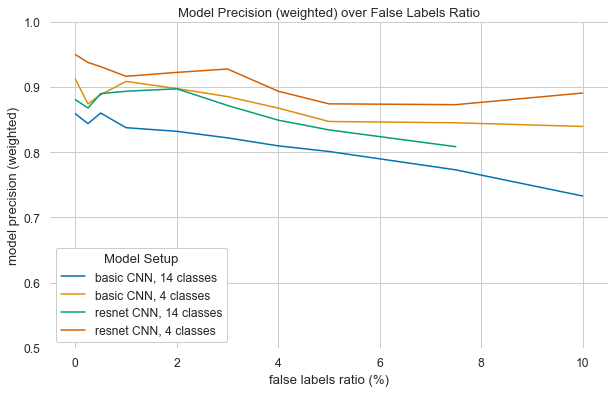

In [473]:
df_hue = df_epoch_precision_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_epoch_precision_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model precision (weighted)',
            ylim=(0.5,1),
            title='Model Precision (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_precision.png', dpi=300, facecolor='white')

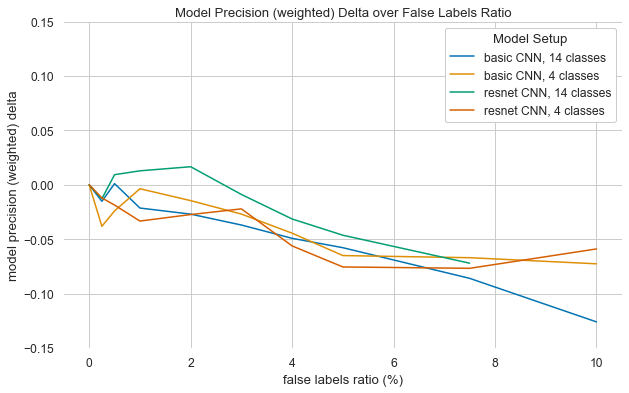

In [474]:
df_hue = df_epoch_precision_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_epoch_precision_w,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model precision (weighted) delta',
            ylim=(-0.15,0.15),
            title='Model Precision (weighted) Delta over False Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_precision_delta.png', dpi=300, facecolor='white')

------------

#### weighted avg recall plot

In [464]:
df_epoch_recall_w = df_aggr.query("tag == 'epoch_recall_weighted'")
df_epoch_recall_w = df_epoch_recall_w.groupby(['model', 'classes', 'ratio', 'data', 'tag']).mean().reset_index()
df_epoch_recall_w.head()

,model,classes,ratio,data,tag,step,value,delta
0,basic,14,0.00,test,epoch_recall_weighted,19.0,0.845858,0.000000
1,basic,14,0.25,test,epoch_recall_weighted,19.0,0.832078,-0.013780
2,basic,14,0.50,test,epoch_recall_weighted,19.0,0.841190,-0.004669
3,basic,14,1.00,test,epoch_recall_weighted,19.0,0.823117,-0.022741
4,basic,14,2.00,test,epoch_recall_weighted,19.0,0.820331,-0.025527


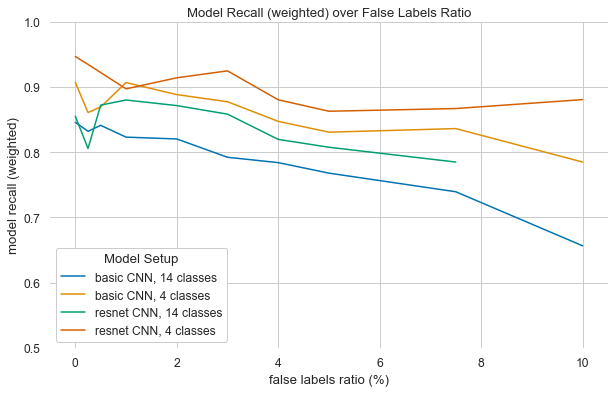

In [465]:
df_hue = df_epoch_recall_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_epoch_recall_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model recall (weighted)',
            ylim=(0.5,1),
            title='Model Recall (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_recall.png', dpi=300, facecolor='white')

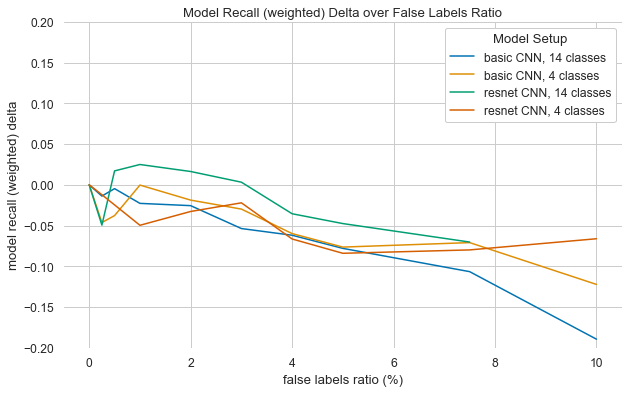

In [477]:
df_hue = df_epoch_recall_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_epoch_recall_w,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model recall (weighted) delta',
            ylim=(-0.2,0.2),
            title='Model Recall (weighted) Delta over False Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_recall_delta.png', dpi=300, facecolor='white')

------------

#### weighted avg f1-score plot

In [480]:
df_epoch_f1score_w = df_aggr.query("tag == 'epoch_f1-score_weighted'")
df_epoch_f1score_w = df_epoch_f1score_w.groupby(['model', 'classes', 'ratio', 'data', 'tag']).mean().reset_index()
df_epoch_f1score_w.head()

,model,classes,ratio,data,tag,step,value,delta
0,basic,14,0.00,test,epoch_f1-score_weighted,19.0,0.846319,0.000000
1,basic,14,0.25,test,epoch_f1-score_weighted,19.0,0.831295,-0.015024
2,basic,14,0.50,test,epoch_f1-score_weighted,19.0,0.838249,-0.008070
3,basic,14,1.00,test,epoch_f1-score_weighted,19.0,0.820368,-0.025951
4,basic,14,2.00,test,epoch_f1-score_weighted,19.0,0.819614,-0.026705


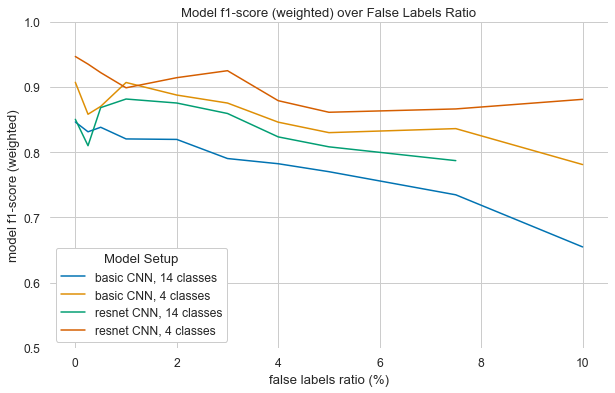

In [481]:
df_hue = df_epoch_f1score_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_epoch_f1score_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model f1-score (weighted)',
            ylim=(0.5,1),
            title='Model f1-score (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_f1score.png', dpi=300, facecolor='white')

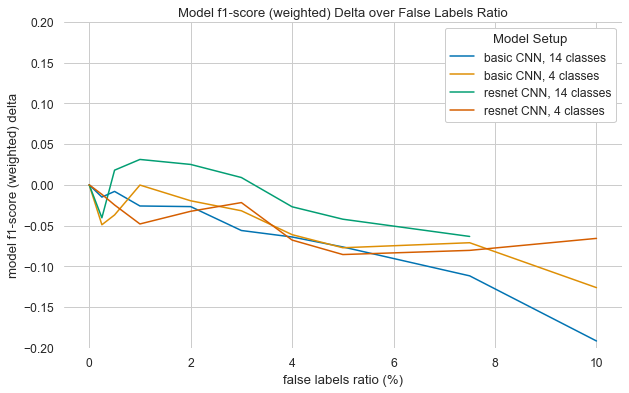

In [484]:
df_hue = df_epoch_f1score_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_epoch_f1score_w,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model f1-score (weighted) delta',
            ylim=(-0.2,0.2),
            title='Model f1-score (weighted) Delta over False Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_f1score_delta.png', dpi=300, facecolor='white')

In [468]:
print('Hello World!')

Hello World!
